# Webscrapping Macroeconomic Data and news event on Forex Factory
### Import the necessary libraries

- Pandas to create a data frame and store data
- Time to refresh the page
- Request to make request about a particular website
- BeautifulSoup to parse the document using ‘lxml’
- WebDriver to perform action on Website

In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
from selenium import webdriver

import warnings
warnings.filterwarnings("ignore")

# Part 1: 
## Retrieving macroeconmoic indicators from Trading Economics

- The code below works on most of Trading Economics Indicators, user can simply add any additional macroeconomic data by inputting an additional key

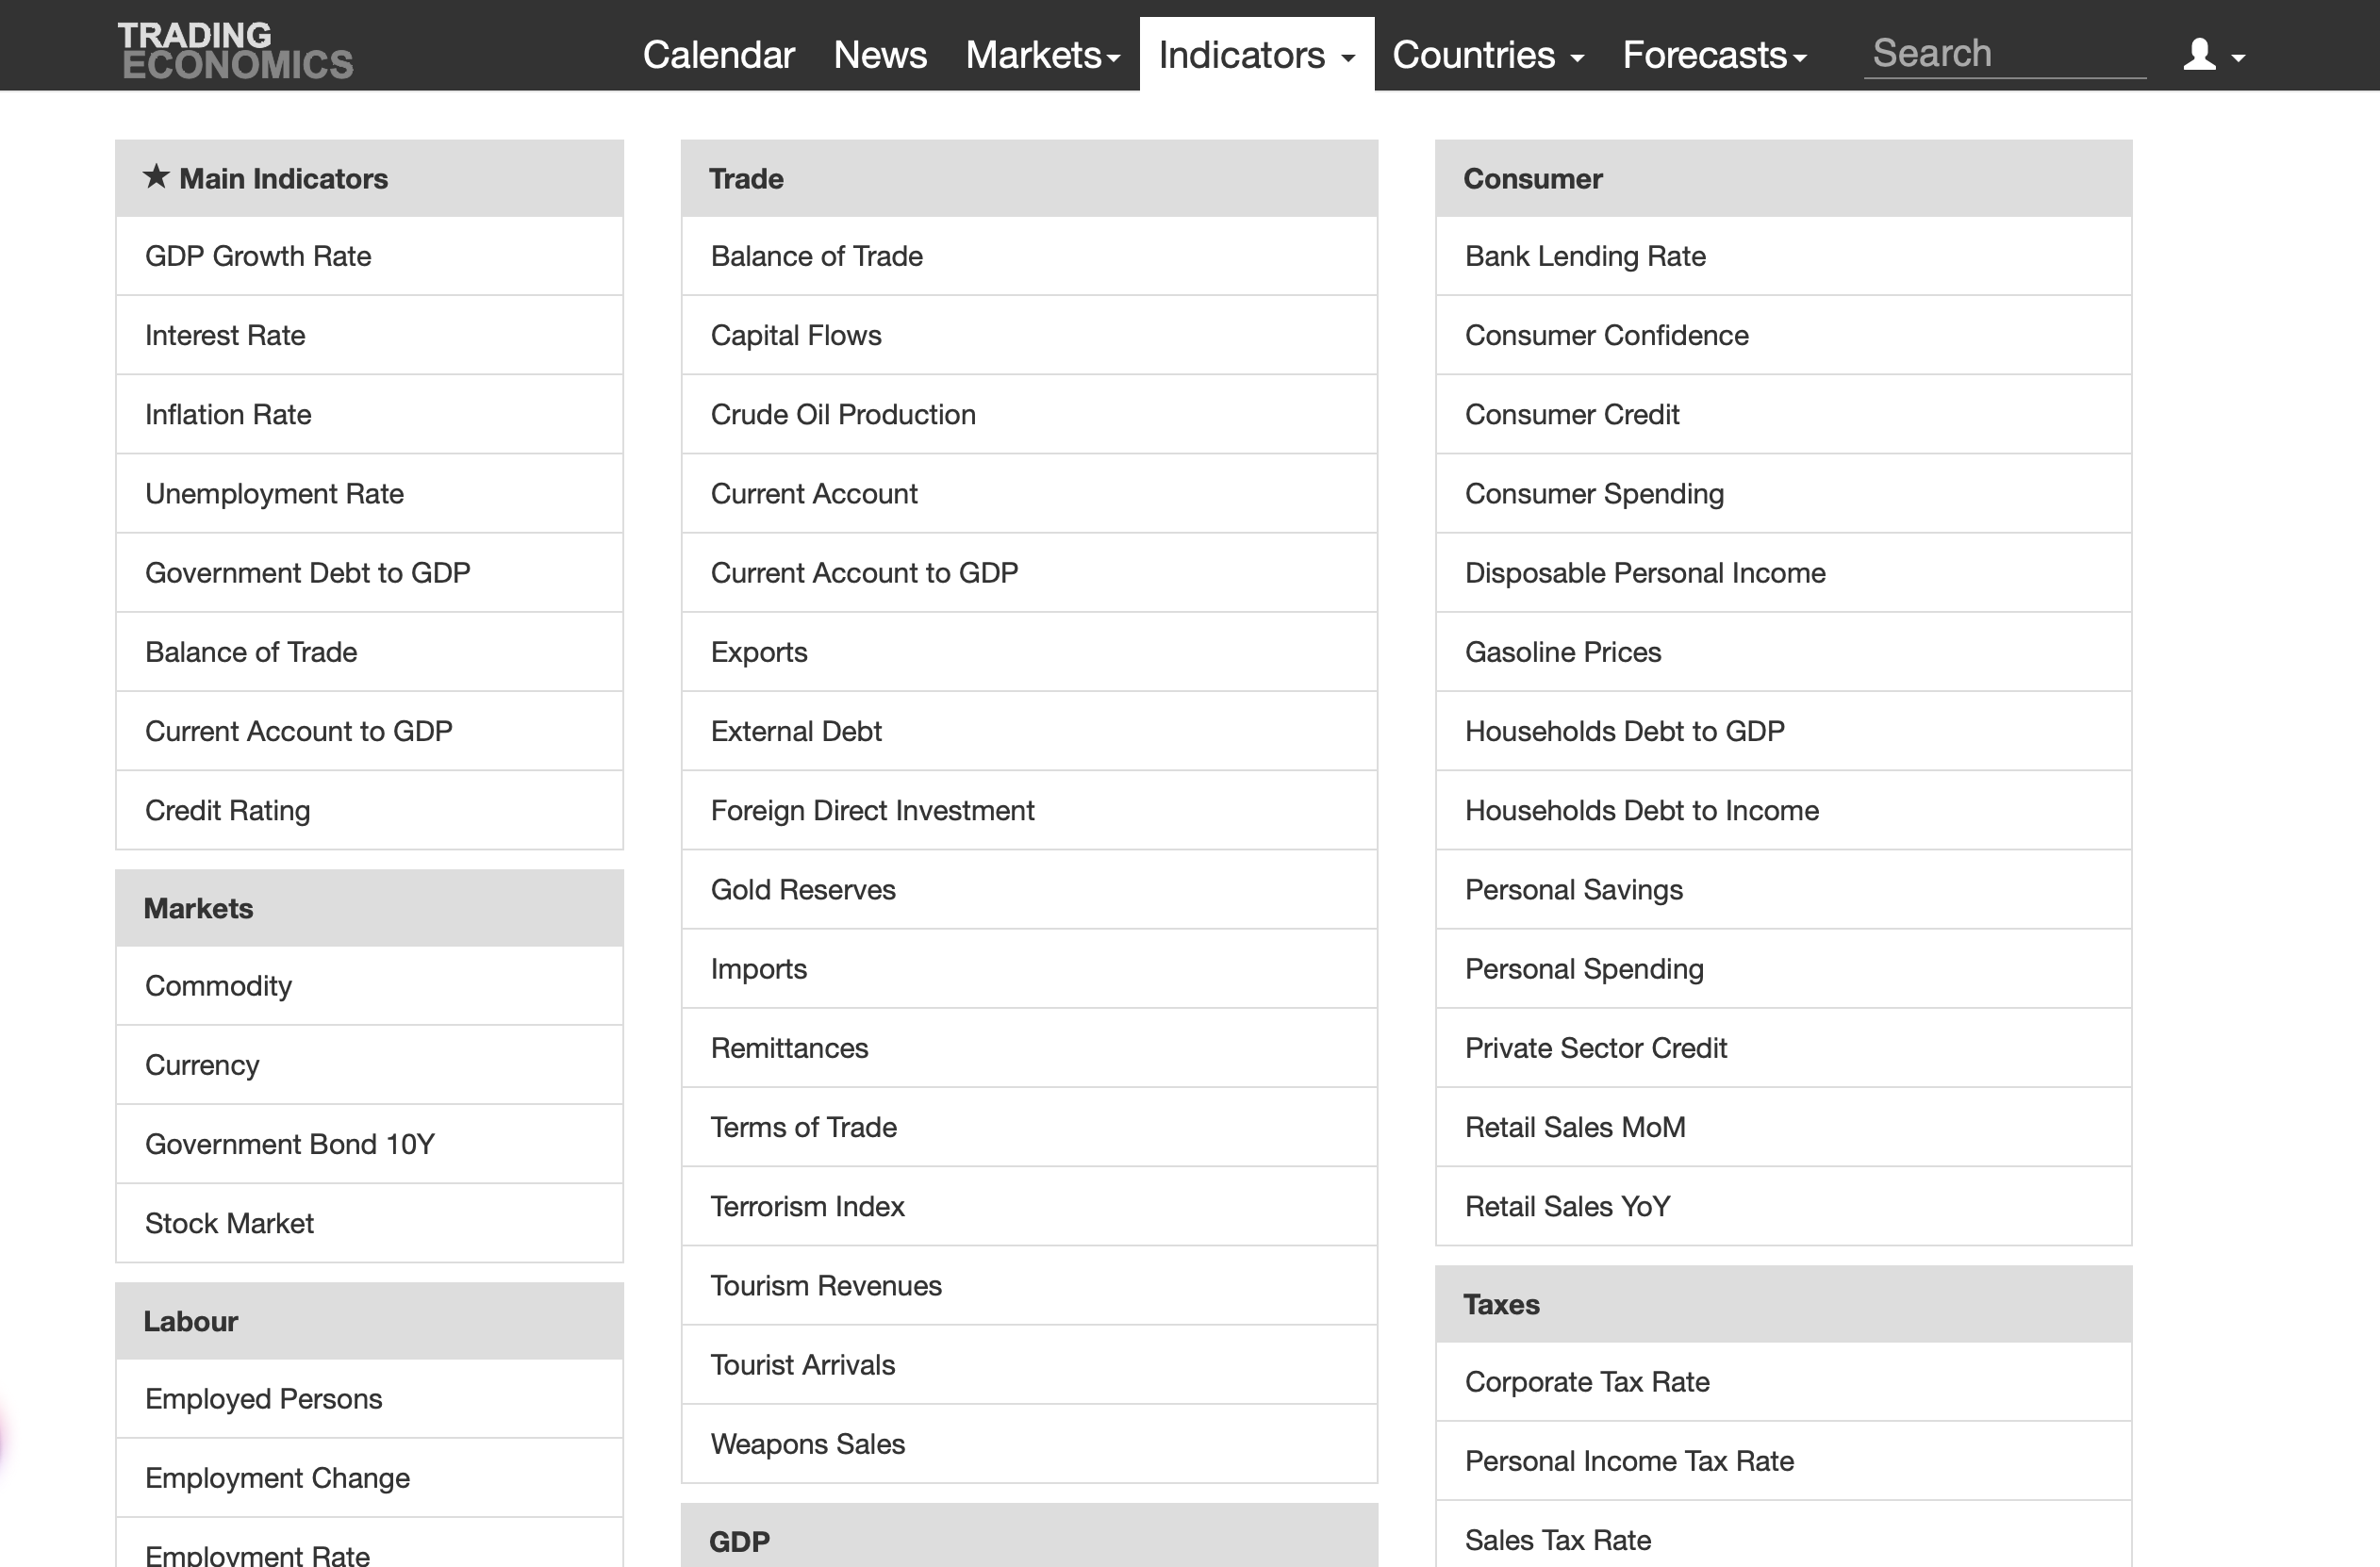

The Key to add is available at the end of the URL: here "gdp-constant-prices"

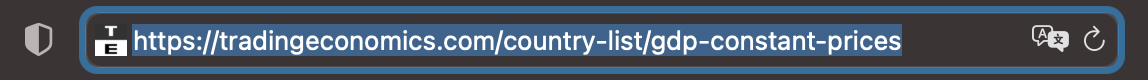

In [3]:
# URLS, add here the additional keys if needed

keys = ["gdp-growth-rate", "inflation-rate", "interest-rate",
        "unemployment-rate", "government-debt-to-gdp", 
        "balance-of-trade", "current-account-to-gdp"]

def get_all_url():
     
    list_of_url = []
    
    # URLs follow the same format according to the indicator
    
    for i in range(0, len(keys)):
        url = f"https://tradingeconomics.com/country-list/{keys[i]}?continent=world"
        list_of_url.append(url)
        
    return list_of_url

In [4]:
def get_data_frame():
    
    
    list_of_url = get_all_url()
    
    soups = []
    
    # Adding this header to avoid getting blocked by the website
    
    headers = {'User-Agent': 
                'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
            
    for i in range(len(list_of_url)):
        
        # Gather all useful HTML
        
        r = requests.get(list_of_url[i], headers=headers)
        soup = BeautifulSoup(r.content, "html.parser")
        soups.append(soup)
    
    count = 0
    
    df_list = []
    
    for soup in soups:

        # Looking for the data tables for each URL
        
        div = soup.find('table', class_='table table-hover table-heatmap')
        th = div.find_all('th')

        columns_names = []

        for item in th:
            columns_names.append(item.text.strip())

        rows_list = []

        rows = soup.find_all("tr", class_="datatable-row")

        for row in rows:

            row_object = []

            for item in row.find_all("td"):

                row_object.append(item.text.strip())

            rows_list.append(row_object)   

        #Converting to dataframe and append to the list of dataframes
        exec("df_"+str(count)+" = pd.DataFrame(rows_list, columns =columns_names)")
        exec("df_list.append("+"df_"+str(count)+")")
    return df_list

In [5]:
def get_data_csv():
    
    data_frame = get_data_frame()

    # We now we'll loop the list of dataframes
    for i, df in enumerate(data_frame):
        df.to_csv(f"CSV/{keys[i]}.csv", index=False)
        
        
        
# Save CSV 

get_data_csv()

In [6]:
# Create a global DataFrame

data_frame_macro = {}

for elem in keys:
    data_frame_macro[elem] = pd.read_csv(f"CSV/{elem}.csv",index_col=None)[['Country', 'Last']]
    data_frame_macro[elem]['Last-' + str(elem)] = data_frame_macro[elem]['Last']
    del data_frame_macro[elem]['Last']

In [7]:
# Merge MacroEconomic Indicators per Country

df = data_frame_macro['gdp-growth-rate']
for another_df in keys[1:]:
    df = pd.merge(left = df, on = 'Country', how = 'outer',
                 right = data_frame_macro[another_df]) 


df.to_csv('CSV/all_data.csv', index = False)

# Part 2: 

## Retrieving news (figure announcments) from forexfactory.

In [8]:
def get_data_frame_news():
  
  # Focusing on the current month
    
  month = "Nov" # change the month to last to make it run automatically on the last month
  year = "2022" # change year if desired
    
  url = f'https://www.forexfactory.com/calendar?month={month}.{year}'


  # we use sleep of 3 second to make sure data is fully loaded
    
  driver = webdriver.Firefox() #change to other navigator if needed
  driver.get(url)
  time.sleep(3)
  html = driver.page_source
  soup = BeautifulSoup(html,'html.parser')
  driver.quit()


  table_news = soup.find('table', class_='calendar__table')
  list_of_rows = []

  #Filtering events that have a href link

  for row in table_news.find_all('tr', {'data-eventid':True}):
      list_of_cells = []
      
      #Filtering high-impact events
      
      for span in row.find_all('span', class_='high'):
          
          #Extracting the values from the table data in each table row
          
          for cell in row.find_all('td', class_=[
            'calendar__cell calendar__currency currency',
            'calendar__cell calendar__date date',  
            'calendar__cell calendar__time time',  
            'calendar__cell calendar__event event', 
            'calendar__cell calendar__actual actual', 
            'calendar__cell calendar__forecast forecast', 
            'calendar__cell calendar__previous previous']):
              
              list_of_cells.append(cell.text)
          list_of_rows.append(list_of_cells)

      for span in row.find_all('span', class_='low'):
          
          #Extracting the values from the table data in each table row
          
          for cell in row.find_all('td', class_=[
            'calendar__cell calendar__currency currency',
            'calendar__cell calendar__date date',  
            'calendar__cell calendar__time time',  
            'calendar__cell calendar__event event', 
            'calendar__cell calendar__actual actual', 
            'calendar__cell calendar__forecast forecast', 
            'calendar__cell calendar__previous previous']):
              
              list_of_cells.append(cell.text)
          list_of_rows.append(list_of_cells)

  df_news = pd.DataFrame(list_of_rows, columns =
  ['Date', 'Time','Currency', 'Event_Title', 'Actual', 'Forecast', 'Previous'])



  # clean the data

  df_news.Date = df_news.Date.str.split(' ').str[2] + " " + df_news.Date.str.split(' ').str[1].str[-3:]
  df_news.Date = df_news.Date.fillna(method='ffill')

  df_news.Time = df_news.Time.str.split('\n').str[1].str[:-2] + ' ' + df_news.Time.str.split('\n').str[1].str[-2:]
  df_news.Time.fillna('', inplace=True)

  df_news.Currency = df_news.Currency.str.split('\n').str[1]
  df_news.Date = df_news.Date.fillna("1 " + month)
  df_news = df_news

  return df_news

In [9]:
# Run this Cell to Save News as CSV file 

def get_data_news_csv():
    data_frame = get_data_frame_news()
    data_frame.to_csv("CSV/News.csv", index=False)

get_data_news_csv()